# Bias Detection in Articles Using Linguistic and Structural Features

<b>Project Description:</b>

This project is part of the May DS Code Pudding challenge. The goal is to collaboratively build a machine learning model that detects bias in articles at the sentence level. By analyzing both the language and structure of text, we aim to classify sentences as either biased or unbiased, and assign an overall bias score to entire articles.

I am responsible for the data preparation phase. This includes:


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing the dataset
df = pd.read_csv('articles.csv')

In [3]:
# Displaying the first few rows of the dataset
display(df.head())

# Displaying the shape of the dataset
print(f"Shape of the dataset: {df.shape}")

# Displaying the columns of the dataset
print(f"Columns in the dataset: {df.columns}")

# Displaying the data types of the columns
print(f"Data types of the columns:\n{df.dtypes}")


,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


Shape of the dataset: (2096, 12)
Columns in the dataset: Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'label', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage'],
      dtype='object')
Data types of the columns:
author                      object
published                   object
title                       object
text                        object
language                    object
site_url                    object
main_img_url                object
type                        object
label                       object
title_without_stopwords     object
text_without_stopwords      object
hasImage                   float64
dtype: object


In [4]:
df.info()

# Finding the number of missing values in each column
print(f"Missing values in each column:\n{df.isnull().sum()}")

# Checking for duplicates in the dataset
print(f"Number of duplicate rows: {df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2096 non-null   object 
 1   published                2096 non-null   object 
 2   title                    2096 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2095 non-null   object 
 5   site_url                 2095 non-null   object 
 6   main_img_url             2095 non-null   object 
 7   type                     2095 non-null   object 
 8   label                    2095 non-null   object 
 9   title_without_stopwords  2094 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2095 non-null   float64
dtypes: float64(1), object(11)
memory usage: 196.6+ KB
Missing values in each column:
author                      0
published            

# Dataset Summary
Total rows: 2,096

Total columns: 12

Key text columns: title, text, title_without_stopwords, text_without_stopwords

Target label: label (exact value distribution TBD)

Missing data: Some rows have missing values in text, label, and language

Language column exists: Important for filtering non-English content

Stopwords removed text is available: Helpful for NLP processing

Image info (hasImage) and site_url: Can be used as structural features

# Step 1: Filter & Clean the Data

In [5]:
# Dropping missing values on the columes 
df= df.dropna()
print(f"Missing values in each column:\n{df.isnull().sum()}")

Missing values in each column:
author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
label                      0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
dtype: int64


In [6]:
# Dropping duplicates in the dataset
df = df.drop_duplicates()
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [7]:
# Filtering the English articles from language column
df = df[df['language'] == 'english']

# Displaying the shape of the dataset after filtering
print(f"Shape of the dataset after filtering English articles: {df.shape}")

Shape of the dataset after filtering English articles: (1957, 12)


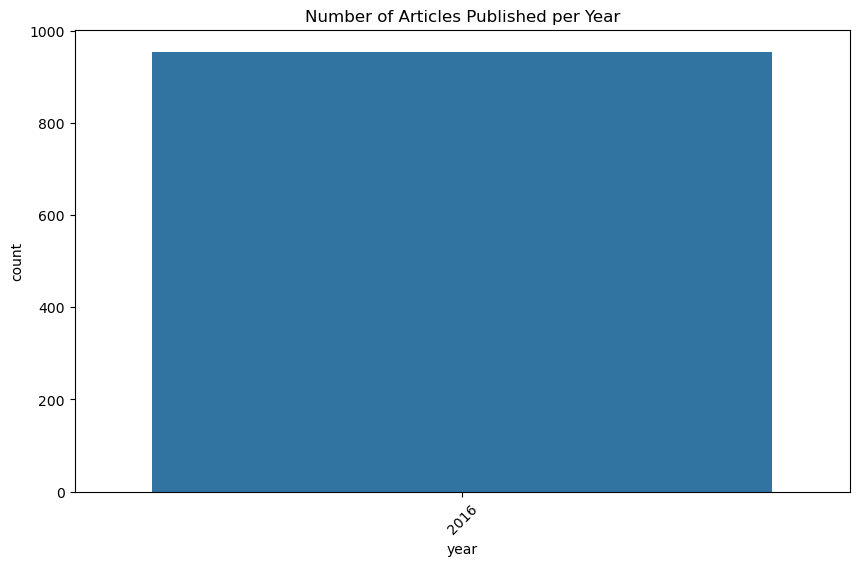

In [10]:
# Converting the 'published' column to datetime format
df['published'] = pd.to_datetime(df['published'], errors='coerce')

# Dropping rows where 'published' could not be converted to datetime
df = df.dropna(subset=['published'])

# Ensuring the 'published' column is in datetime format
from pandas.api.types import is_datetime64_any_dtype

if not is_datetime64_any_dtype(df['published']):
	raise ValueError("The 'published' column could not be converted to datetime format.")

# Extracting the year from the 'published' column
df['year'] = df['published'].dt.year

# Plotting the number of articles published per year
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=df, order=sorted(df['year'].unique()))
plt.title('Number of Articles Published per Year')
plt.xticks(rotation=45)
plt.show()

# Step 2: Understand Your Labels


In [11]:
# Exploring the labels
print(f"Labels in the dataset:\n{df['label'].value_counts()}")

Labels in the dataset:
label
Fake    593
Real    361
Name: count, dtype: int64


In [12]:
# Labeling the dataset
df['is_biased'] = df['label'].map({'Fake' : 1, 'Real': 0})
df['is_biased'].value_counts()

is_biased
1    593
0    361
Name: count, dtype: int64

In [13]:
# Updating the column names to be more consistent
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print(f"Standardized column names: {df.columns.tolist()}")

Standardized column names: ['author', 'published', 'title', 'text', 'language', 'site_url', 'main_img_url', 'type', 'label', 'title_without_stopwords', 'text_without_stopwords', 'hasimage', 'year', 'is_biased']


# Step 3: Plotting 

label
Fake    593
Real    361
Name: count, dtype: int64


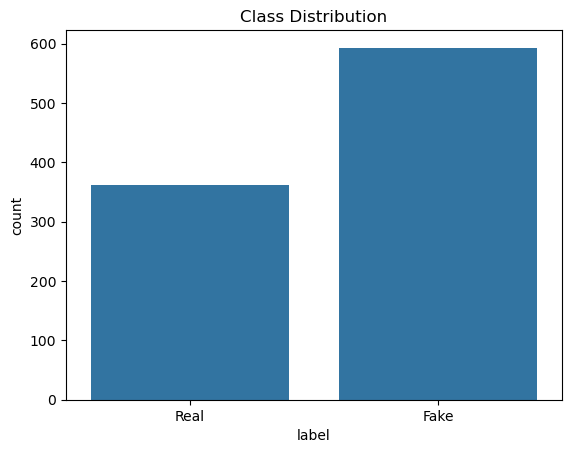

In [14]:
# Check class distribution
if 'label' in df.columns:
    print(df['label'].value_counts())
    sns.countplot(x='label', data=df)
    plt.title('Class Distribution')
    plt.show()

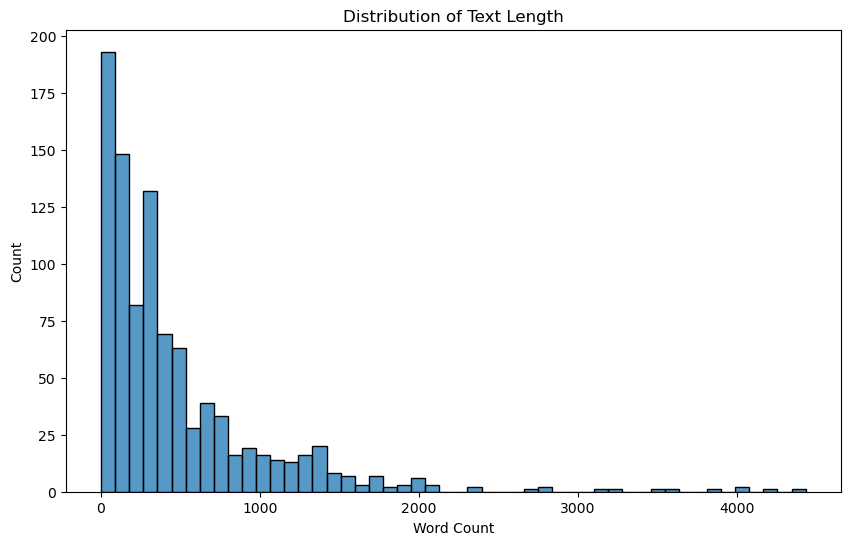

In [15]:
# Displaying the distribution of article lengths and outliers
plt.figure(figsize=(10, 6))
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Word Count')
plt.show()

In [16]:
# Displaying the summary statistics of text length grouped by label
df.groupby('label')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Fake,593.0,489.080944,564.528071,1.0,141.0,316.0,627.0,4431.0
Real,361.0,448.479224,558.911939,2.0,91.0,246.0,615.0,3989.0


In [17]:
# Visualizing the average text length by label
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='hasImage', data=df)
plt.title('Proportion of Articles with Images by Label')

ValueError: Could not interpret value `hasImage` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

## 📊 EDA Summary: Bias Detection Dataset

### 1. Label Distribution (Fake vs. Real)
- The dataset is **imbalanced**, with:
  - **Fake articles**: ~58%
  - **Real articles**: ~42%
- This class imbalance may affect model training and should be addressed.

---

### 2. Text Length Distribution
- Most articles are **short**, under **500 words**.
- The distribution is **heavily right-skewed**, with a few very long articles (up to ~6,000 words).

---

### 3. Image Presence by Label
- **Real articles** are more likely to contain images (~83%) compared to **Fake articles** (~73%).
- This suggests image inclusion could be a **useful structural feature** correlated with article credibility or bias.

---

### 📝 Overall Implications
- The dataset is clean and ready for feature engineering.
- There are detectable differences between Fake and Real articles in both **length and structure**.
- These insights support the importance of combining **linguistic** and **structural** features in the downstream modeling phase.